In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from scipy.ndimage import sobel, gaussian_filter, uniform_filter, maximum_filter


In [2]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/data/chessboard.png -O chessboard.png
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/data/sudoku.png -O sudoku.png
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/data/building.jpg -O building.jpg


--2026-02-04 16:47:59--  https://raw.githubusercontent.com/opencv/opencv/master/samples/data/chessboard.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27835 (27K) [image/png]
Saving to: ‘chessboard.png’

chessboard.png      100%[===================>]  27.18K  --.-KB/s    in 0.002s  

2026-02-04 16:47:59 (13.0 MB/s) - ‘chessboard.png’ saved [27835/27835]

--2026-02-04 16:47:59--  https://raw.githubusercontent.com/opencv/opencv/master/samples/data/sudoku.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250720 (245K) [image/p

In [3]:
images = {}
paths = {
    "Chessboard": "chessboard.png",
    "Sudoku": "sudoku.png",
    "Building": "building.jpg"
}

for name, path in paths.items():
    img = cv2.imread(path)
    if img is None:
        raise RuntimeError(f"Failed to load {path}")
    images[name] = img


In [4]:
gray_images = {}

for name, img in images.items():
    gray_images[name] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)


In [5]:
def harris_corners_beginner(
    gray,
    block_size=5,
    k=0.04,
    percentile=99.7,
    nms_radius=6,
    top_n=200
):
    Ix = sobel(gray, axis=1)
    Iy = sobel(gray, axis=0)

    Ixx = gaussian_filter(Ix * Ix, sigma=1)
    Iyy = gaussian_filter(Iy * Iy, sigma=1)
    Ixy = gaussian_filter(Ix * Iy, sigma=1)

    Sxx = uniform_filter(Ixx, size=block_size)
    Syy = uniform_filter(Iyy, size=block_size)
    Sxy = uniform_filter(Ixy, size=block_size)

    det = Sxx * Syy - Sxy ** 2
    trace = Sxx + Syy
    R = det - k * (trace ** 2)

    thresh = np.percentile(R, percentile)
    R[R < thresh] = 0

    local_max = maximum_filter(R, size=2 * nms_radius + 1)
    mask = (R == local_max) & (R > 0)

    ys, xs = np.where(mask)
    scores = R[ys, xs]

    order = np.argsort(scores)[::-1][:top_n]
    corners = [(int(ys[i]), int(xs[i]), scores[i]) for i in order]

    return corners, R


In [6]:
def subpixel_refine(R, y, x):
    if y <= 0 or y >= R.shape[0]-1 or x <= 0 or x >= R.shape[1]-1:
        return float(y), float(x)

    dx = (R[y, x+1] - R[y, x-1]) / 2
    dy = (R[y+1, x] - R[y-1, x]) / 2
    dxx = R[y, x+1] - 2*R[y, x] + R[y, x-1]
    dyy = R[y+1, x] - 2*R[y, x] + R[y-1, x]

    x_off = -dx / dxx if dxx != 0 else 0
    y_off = -dy / dyy if dyy != 0 else 0

    return y + y_off, x + x_off


In [7]:
def refine_corners(corners, R):
    refined = []
    for y, x, s in corners:
        ry, rx = subpixel_refine(R, y, x)
        refined.append((ry, rx, s))
    return refined


In [8]:
def fast_detector_beginner(gray, threshold=30, n=9, nms_radius=3):
    gray = gray.astype(np.int32)
    h, w = gray.shape
    score_map = np.zeros_like(gray, dtype=np.float32)

    circle = [
        (0,3),(1,3),(2,2),(3,1),(3,0),(3,-1),(2,-2),(1,-3),
        (0,-3),(-1,-3),(-2,-2),(-3,-1),(-3,0),(-3,1),(-2,2),(-1,3)
    ]

    for y in range(3, h-3):
        for x in range(3, w-3):
            center = gray[y, x]
            diffs = np.array([abs(gray[y+dy, x+dx] - center) for dx, dy in circle])

            bright = diffs > threshold
            max_run = run = 0
            for v in bright:
                run = run + 1 if v else 0
                max_run = max(max_run, run)

            if max_run >= n:
                score_map[y, x] = np.sum(diffs)

    local_max = maximum_filter(score_map, size=2*nms_radius + 1)
    mask = (score_map == local_max) & (score_map > 0)

    ys, xs = np.where(mask)
    scores = score_map[ys, xs]

    return [(int(y), int(x), scores[i]) for i, (y, x) in enumerate(zip(ys, xs))]


In [9]:
harris_results = {}
fast_results = {}

for name, gray in gray_images.items():
    corners, R = harris_corners_beginner(gray)
    harris_results[name] = refine_corners(corners, R)
    fast_results[name] = fast_detector_beginner(gray)


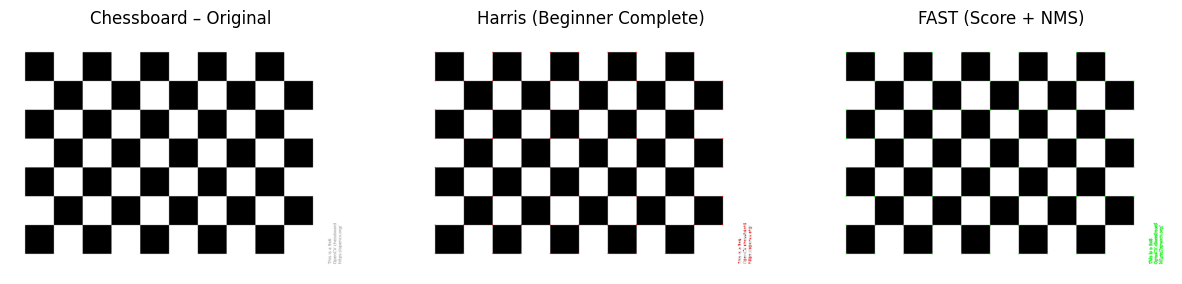

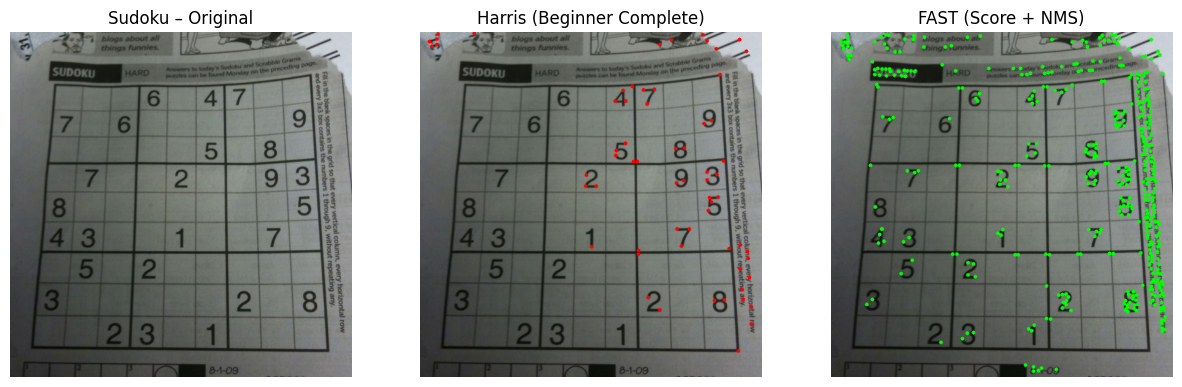

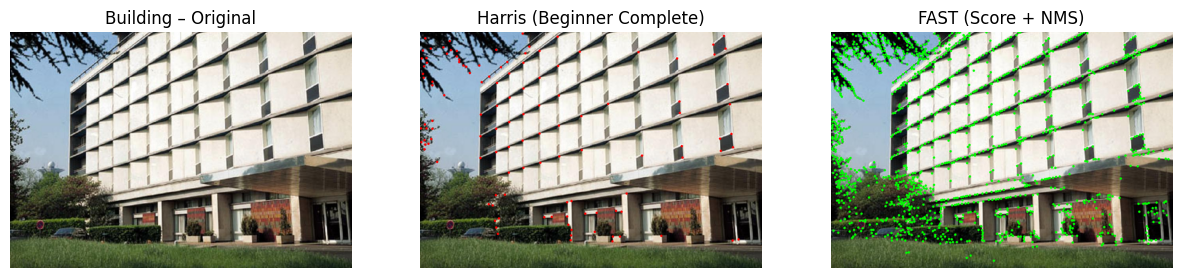

In [10]:
def draw_corners(img, corners, color):
    out = img.copy()
    for y, x, _ in corners:
        cv2.circle(out, (int(x), int(y)), 3, color, -1)
    return out

for name in images:
    harris_img = draw_corners(images[name], harris_results[name], (0,0,255))
    fast_img   = draw_corners(images[name], fast_results[name], (0,255,0))

    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.imshow(cv2.cvtColor(images[name], cv2.COLOR_BGR2RGB))
    plt.title(f"{name} – Original")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(cv2.cvtColor(harris_img, cv2.COLOR_BGR2RGB))
    plt.title("Harris (Beginner Complete)")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(cv2.cvtColor(fast_img, cv2.COLOR_BGR2RGB))
    plt.title("FAST (Score + NMS)")
    plt.axis("off")

    plt.show()


# Intermediate

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import sobel, gaussian_filter, maximum_filter


In [12]:
def shi_tomasi_corners(gray, block_size=5, nms_radius=6, percentile=99.7, top_n=200):
    Ix = sobel(gray, axis=1)
    Iy = sobel(gray, axis=0)

    Ixx = gaussian_filter(Ix * Ix, sigma=1)
    Iyy = gaussian_filter(Iy * Iy, sigma=1)
    Ixy = gaussian_filter(Ix * Iy, sigma=1)

    Sxx = gaussian_filter(Ixx, sigma=block_size)
    Syy = gaussian_filter(Iyy, sigma=block_size)
    Sxy = gaussian_filter(Ixy, sigma=block_size)

    # Shi–Tomasi response = min(eigenvalues)
    trace = Sxx + Syy
    det = Sxx * Syy - Sxy ** 2
    lambda_min = trace / 2 - np.sqrt((trace / 2) ** 2 - det)

    thresh = np.percentile(lambda_min, percentile)
    R = np.where(lambda_min > thresh, lambda_min, 0)

    local_max = maximum_filter(R, size=2 * nms_radius + 1)
    mask = (R == local_max) & (R > 0)

    ys, xs = np.where(mask)
    scores = R[ys, xs]
    order = np.argsort(scores)[::-1][:top_n]

    return [(int(ys[i]), int(xs[i]), scores[i]) for i in order]


In [13]:
def multiscale_fast(gray, scales=[1.0, 0.75, 0.5], threshold=30):
    all_keypoints = []

    for scale in scales:
        resized = cv2.resize(gray, None, fx=scale, fy=scale)
        fast = cv2.FastFeatureDetector_create(threshold=threshold, nonmaxSuppression=True)
        kps = fast.detect(resized.astype(np.uint8))

        for kp in kps:
            x = kp.pt[0] / scale
            y = kp.pt[1] / scale
            all_keypoints.append((int(y), int(x), scale))

    return all_keypoints


In [14]:
def rotation_repeatability(gray, angles=[5, 15, 30, 45]):
    base_fast = cv2.FastFeatureDetector_create()
    base_kp = base_fast.detect(gray.astype(np.uint8))
    base_pts = set([(int(k.pt[0]), int(k.pt[1])) for k in base_kp])

    results = {}

    h, w = gray.shape
    center = (w // 2, h // 2)

    for angle in angles:
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(gray, M, (w, h))

        kp_rot = base_fast.detect(rotated.astype(np.uint8))
        pts_rot = set([(int(k.pt[0]), int(k.pt[1])) for k in kp_rot])

        common = base_pts & pts_rot
        repeatability = len(common) / max(len(base_pts), 1)
        results[angle] = repeatability

    return results


In [15]:
def temporal_consistency(video_path, max_frames=30):
    cap = cv2.VideoCapture(video_path)
    fast = cv2.FastFeatureDetector_create()
    prev_pts = None
    frame_id = 0

    while cap.isOpened() and frame_id < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        kps = fast.detect(gray)
        pts = set([(int(k.pt[0]), int(k.pt[1])) for k in kps])

        if prev_pts is not None:
            stable = prev_pts & pts
            print(f"Frame {frame_id}: stable corners = {len(stable)}")

        prev_pts = pts
        frame_id += 1

    cap.release()


In [16]:
for name, img in images.items():
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    shi = shi_tomasi_corners(gray)
    ms_fast = multiscale_fast(gray)

    print(f"{name}:")
    print(f"  Shi–Tomasi corners: {len(shi)}")
    print(f"  Multi-scale FAST corners: {len(ms_fast)}")


/tmp/ipython-input-1671284708.py:16: RuntimeWarning: invalid value encountered in sqrt
  lambda_min = trace / 2 - np.sqrt((trace / 2) ** 2 - det)


Chessboard:
  Shi–Tomasi corners: 0
  Multi-scale FAST corners: 896
Sudoku:
  Shi–Tomasi corners: 0
  Multi-scale FAST corners: 1839
Building:
  Shi–Tomasi corners: 0
  Multi-scale FAST corners: 5140


/tmp/ipython-input-1671284708.py:16: RuntimeWarning: invalid value encountered in sqrt
  lambda_min = trace / 2 - np.sqrt((trace / 2) ** 2 - det)


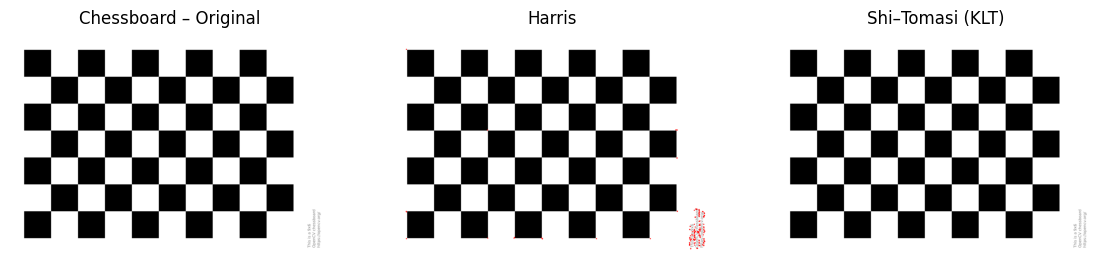

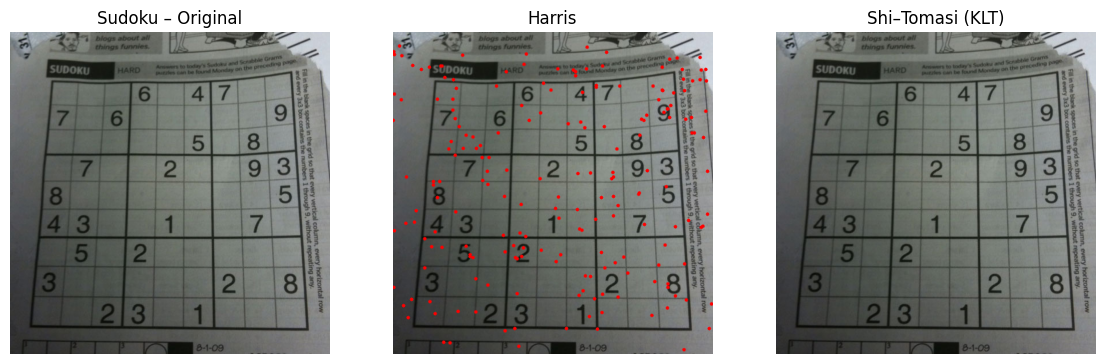

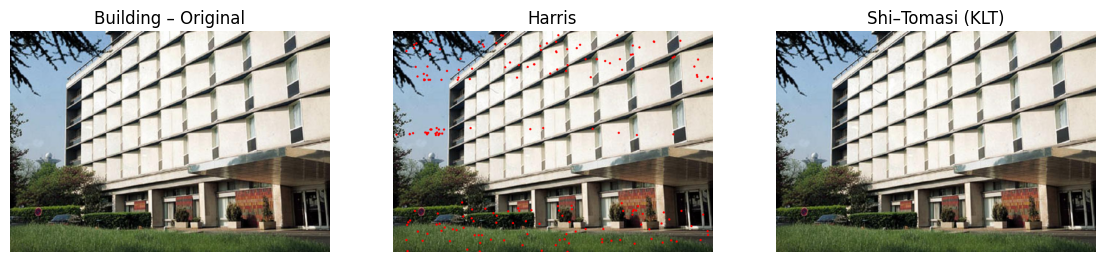

In [17]:
def draw_points(img, points, color):
    out = img.copy()
    for y, x, _ in points:
        cv2.circle(out, (x, y), 3, color, -1)
    return out

for name, img in images.items():
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    shi = shi_tomasi_corners(gray)
    har, _ = harris_corners_beginner(gray)

    shi_img = draw_points(img, shi, (0, 255, 0))
    har_img = draw_points(img, har, (0, 0, 255))

    plt.figure(figsize=(14,5))

    plt.subplot(1,3,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"{name} – Original")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(cv2.cvtColor(har_img, cv2.COLOR_BGR2RGB))
    plt.title("Harris")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(cv2.cvtColor(shi_img, cv2.COLOR_BGR2RGB))
    plt.title("Shi–Tomasi (KLT)")
    plt.axis("off")

    plt.show()


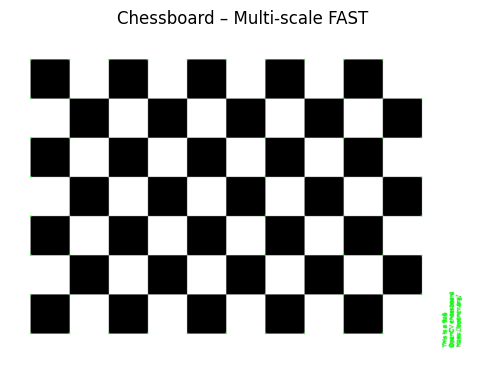

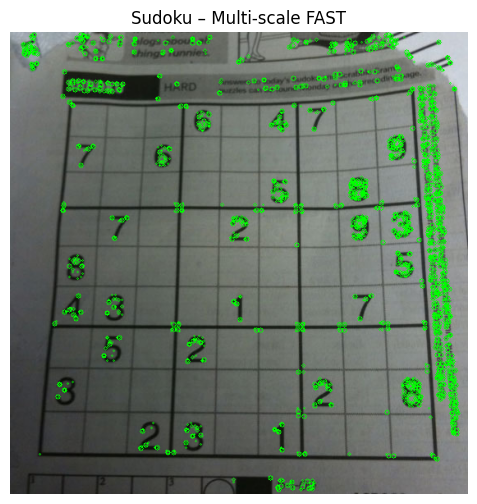

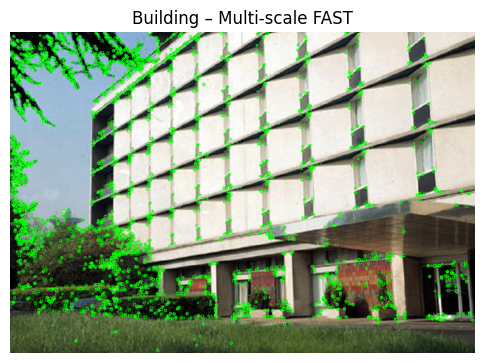

In [18]:
for name, img in images.items():
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ms_fast = multiscale_fast(gray)

    out = img.copy()
    for y, x, scale in ms_fast:
        radius = int(3 * scale)
        cv2.circle(out, (x, y), radius, (0,255,0), 1)

    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
    plt.title(f"{name} – Multi-scale FAST")
    plt.axis("off")
    plt.show()


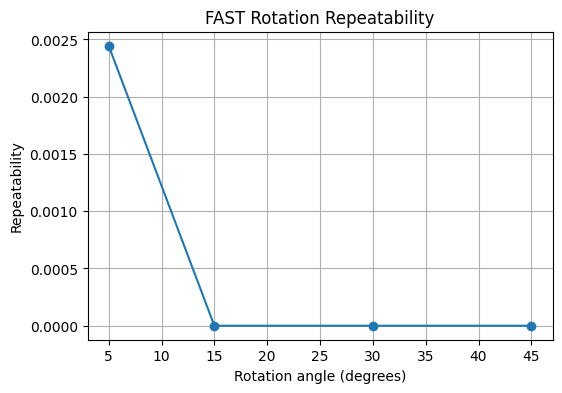

In [19]:
angles = [5, 15, 30, 45]
repeat = rotation_repeatability(gray_images["Chessboard"], angles)

plt.figure(figsize=(6,4))
plt.plot(list(repeat.keys()), list(repeat.values()), marker="o")
plt.xlabel("Rotation angle (degrees)")
plt.ylabel("Repeatability")
plt.title("FAST Rotation Repeatability")
plt.grid(True)
plt.show()


# Advanced


In [22]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
from scipy.spatial.distance import cdist


In [23]:
def opencv_harris(gray):
    gray = np.float32(gray)
    R = cv2.cornerHarris(gray, 2, 3, 0.04)
    ys, xs = np.where(R > 0.01 * R.max())
    return np.column_stack((xs, ys))

def opencv_fast(gray):
    fast = cv2.FastFeatureDetector_create()
    kps = fast.detect(gray)
    return np.array([[int(k.pt[0]), int(k.pt[1])] for k in kps])


In [26]:
def measure_time(func, gray, runs=10):
    times = []
    for _ in range(runs):
        start = time.time()
        func(gray)
        times.append(time.time() - start)
    return np.mean(times)



In [27]:
for name, img in images.items():
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    t_fast_cv = measure_time(opencv_fast, gray)
    t_fast_custom = measure_time(lambda g: fast_detector_beginner(g), gray)

    print(f"{name}")
    print(f"  OpenCV FAST:   {t_fast_cv:.4f} sec")
    print(f"  Custom FAST:   {t_fast_custom:.4f} sec\n")

Chessboard
  OpenCV FAST:   0.0014 sec
  Custom FAST:   32.4293 sec

Sudoku
  OpenCV FAST:   0.0058 sec
  Custom FAST:   4.7868 sec

Building
  OpenCV FAST:   0.0123 sec
  Custom FAST:   7.5742 sec



In [28]:
def repeatability_score(pts1, pts2, tolerance=5):
    if len(pts1) == 0 or len(pts2) == 0:
        return 0.0
    dists = cdist(pts1, pts2)
    matches = np.any(dists < tolerance, axis=1)
    return np.sum(matches) / len(pts1)


In [29]:
def localization_error(pts1, pts2):
    if len(pts1) == 0 or len(pts2) == 0:
        return None
    dists = cdist(pts1, pts2)
    return np.mean(np.min(dists, axis=1))


In [30]:
def extract_patch(gray, x, y, size=5):
    half = size // 2
    return gray[y-half:y+half+1, x-half:x+half+1].flatten()


In [31]:
img1 = images["Sudoku"]
img2 = images["Sudoku"].copy()

# simulate second view
M = cv2.getRotationMatrix2D((img2.shape[1]//2, img2.shape[0]//2), 5, 1.0)
img2 = cv2.warpAffine(img2, M, (img2.shape[1], img2.shape[0]))

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

pts1 = fast_detector_beginner(gray1)[:100]
pts2 = fast_detector_beginner(gray2)[:100]

desc1 = np.array([extract_patch(gray1, x, y) for y, x, _ in pts1])
desc2 = np.array([extract_patch(gray2, x, y) for y, x, _ in pts2])


In [32]:
matches = []
dists = cdist(desc1, desc2)

for i in range(len(desc1)):
    j = np.argmin(dists[i])
    matches.append((i, j))


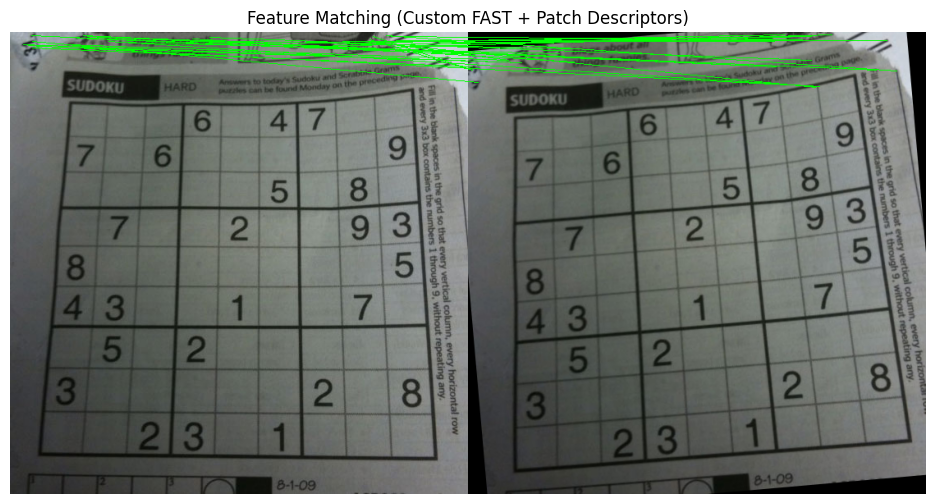

In [33]:
out = np.hstack((img1, img2))
w = img1.shape[1]

for i, j in matches[:30]:
    x1, y1 = int(pts1[i][1]), int(pts1[i][0])
    x2, y2 = int(pts2[j][1]) + w, int(pts2[j][0])
    cv2.line(out, (x1, y1), (x2, y2), (0,255,0), 1)

plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
plt.title("Feature Matching (Custom FAST + Patch Descriptors)")
plt.axis("off")
plt.show()


In [34]:
def save_keypoints(filename, points):
    np.savetxt(filename, points, fmt="%.2f", header="x y score")

for name, img in images.items():
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    pts = fast_detector_beginner(gray)
    save_keypoints(f"{name}_fast_keypoints.txt", pts)
